In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import yfinance as yf

import warnings

warnings.filterwarnings("ignore")

## Importing data

In [77]:
data = yf.download('BZ=F', period='5Y', progress=False)[['Adj Close']]

data['Log Returns'] = np.log(data['Adj Close']).diff()
data['std_today'] = data['Log Returns'].rolling(21).std()
data['std_one_day'] = data['std_today'].shift(-1)
data['std_two_day'] = data['std_today'].shift(-2)
data.dropna(inplace=True)

data['day'] = data.index.dayofweek
data['month'] = data.index.month
data['year'] = data.index.year
data['dayofyear'] = data.index.dayofyear
data['dayofweek'] = data.index.dayofweek
data['weekofyear'] = data.index.weekofyear

display(data)

,Adj Close,Log Returns,std_today,std_one_day,std_two_day,day,month,year,dayofyear,dayofweek,weekofyear
Date,,,,,,,,,,,
2019-02-06,62.689999,0.011390,0.018599,0.018580,0.015839,2,2,2019,37,2,6
2019-02-07,61.630001,-0.017053,0.018580,0.015839,0.015967,3,2,2019,38,3,6
2019-02-08,62.099998,0.007597,0.015839,0.015967,0.015623,4,2,2019,39,4,6
2019-02-11,61.509998,-0.009546,0.015967,0.015623,0.014820,0,2,2019,42,0,7
2019-02-12,62.419998,0.014686,0.015623,0.014820,0.014033,1,2,2019,43,1,7
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,79.650002,-0.017671,0.021885,0.021577,0.021359,2,12,2023,361,2,52
2023-12-28,78.389999,-0.015946,0.021577,0.021359,0.021503,3,12,2023,362,3,52
2023-12-29,77.040001,-0.017372,0.021359,0.021503,0.020199,4,12,2023,363,4,52


## Create model

Epoch 1/20
987/987 [==============================] - 6s 3ms/step - loss: 7.5204e-04
Epoch 2/20
987/987 [==============================] - 3s 3ms/step - loss: 3.3358e-04
Epoch 3/20
987/987 [==============================] - 3s 3ms/step - loss: 3.1753e-04
Epoch 4/20
987/987 [==============================] - 3s 3ms/step - loss: 2.6971e-04
Epoch 5/20
987/987 [==============================] - 3s 3ms/step - loss: 2.6558e-04
Epoch 6/20
987/987 [==============================] - 3s 3ms/step - loss: 2.6430e-04
Epoch 7/20
987/987 [==============================] - 4s 4ms/step - loss: 2.5145e-04
Epoch 8/20
987/987 [==============================] - 4s 4ms/step - loss: 2.4269e-04
Epoch 9/20
987/987 [==============================] - 4s 4ms/step - loss: 2.4521e-04
Epoch 10/20
987/987 [==============================] - 4s 4ms/step - loss: 2.4304e-04
Epoch 11/20
987/987 [==============================] - 4s 4ms/step - loss: 2.3141e-04
Epoch 12/20
987/987 [==============================] - 4s 4ms/s

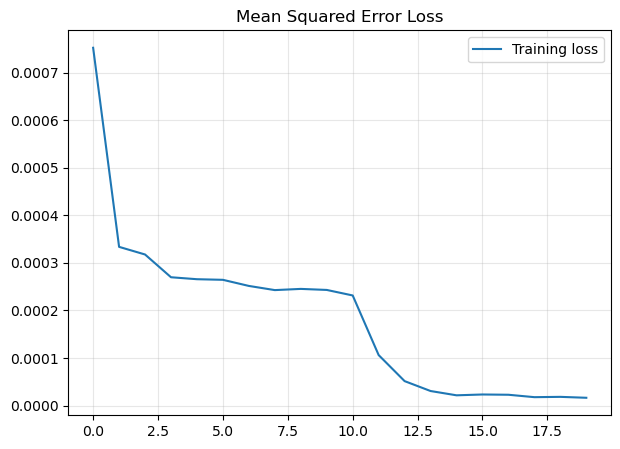

In [97]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1,1))

y = data[['std_one_day', 'std_two_day']].values
X = data.drop(['Adj Close', 'Log Returns'], axis=1).values

# Convert the x and y to numpy arrays
X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Reshape the data into the shape accepted by the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=20)

# Test the model
predictions = model.predict(X_test)

train_loss = history.history['loss']

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(train_loss, label='Training loss')
ax.legend(loc='best')
ax.set_title('Mean Squared Error Loss')
ax.grid(alpha=0.3)
plt.show()


In [99]:
# convert y_test to dataframe for plotting
display(pd.DataFrame(y_test, columns=['std_one_day', 'std_two_day']))

results_one_day = pd.DataFrame({'Actual': y_test[0].flatten(), 'Predictions': predictions[0].flatten()})
results_two_day = pd.DataFrame({'Actual': y_test[1].flatten(), 'Predictions': predictions[1].flatten()})

display(results_one_day)

# Plot predictions and actual values
fig, ax = plt.subplots(figsize=(10,6))
results_one_day[:50].plot(ax=ax)
results_two_day[:50].plot(ax=ax)
ax.plot()
ax.set_title('Volatility Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.legend()


mse = mean_squared_error(y_test, predictions)
print('MSE: ', mse)


,std_one_day,std_two_day
0,0.022856,0.022792
1,0.012025,0.012264
2,0.028454,0.021925
3,0.021037,0.020610
4,0.025879,0.025493
...,...,...
242,0.055887,0.056381
243,0.023352,0.022887
244,0.025075,0.024879
245,0.016480,0.016526


ValueError: All arrays must be of the same length